In [1]:
# set up the environment
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import subprocess

In [2]:
df = pd.read_csv("../data/phages_per_genome.tsv.gz", delimiter='\t', compression='gzip')
df.head()

,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16,2,1,13,48916
1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31,1,10,20,40297
2,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38,6,13,19,268081
3,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46,6,11,29,166286
4,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33,3,9,21,93416


# Which Version Are You Using?

In [3]:
githash = subprocess.check_output(["git", "describe", "--always"]).strip().decode()
print(f"Please note that this was run with git commit {githash} that has {df.shape[0]:,} genomes parsed and {df['Total Predicted Prophages'].sum():,} total prophages")

Please note that this was run with git commit 8872c26 that has 399,582 genomes parsed and 14,967,114 total prophages


In [4]:
# this should be fixed in the next release and could be removed.
# df = df.replace([np.nan], 0)

In [5]:
df['fraction pp'] = df['bp prophage']/df['Genome length']

## Compare genome length and prophage bp

Use statistics!

In [6]:
exog = sm.add_constant(df["Genome length"])
model = sm.OLS(df["bp prophage"], exog).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            bp prophage   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                 3.384e+05
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:52:37   Log-Likelihood:            -4.9905e+06
No. Observations:              399582   AIC:                         9.981e+06
Df Residuals:                  399580   BIC:                         9.981e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.793e+04    290.258    -96.228      0.000   -2.85e+04   -2.74e+04
Genome length     0.0391   6.73e-05    581.737      0.000       0.039       0.039
==============================================================================
Omnibus:                    36661.141   Durbin-Watson:                   1.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           191482.557
Skew:                           0.295   Prob(JB):                         0.00
Kurtosis:                       6.340   Cond. No.                     1.23e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
print(f"The equation is {model.params['Genome length']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for genome length is {model.pvalues['Genome length']:.3f}")

The equation is 0.039x + -27931.023
The R-squared is 0.459
The p-value for genome length is 0.000


In [8]:
df['bp pp fit'] = (model.params['Genome length'] * df['Genome length']) + model.params['const']

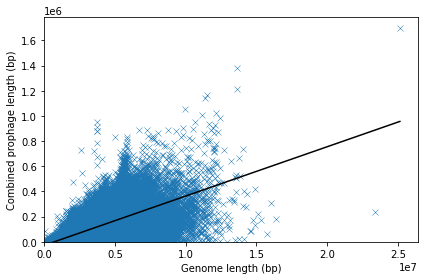

In [9]:
ax = sns.scatterplot(x='Genome length', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Genome length', y='bp pp fit', data=df, color='k')
ax.set_ylabel('Combined prophage length (bp)')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/lengths.png')

## Compare number of prophages and genome length

In [10]:
exog = sm.add_constant(df["Genome length"])
keptmodel = sm.OLS(df["Kept"], exog).fit()
keptmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Kept   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                 2.369e+05
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:01:01   Log-Likelihood:            -1.0652e+06
No. Observations:              399582   AIC:                         2.130e+06
Df Residuals:                  399580   BIC:                         2.130e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.5274      0.016    -97.166      0.000      -1.558      -1.497
Genome length  1.774e-06   3.64e-09    486.774      0.000    1.77e-06    1.78e-06
==============================================================================
Omnibus:                    82156.309   Durbin-Watson:                   0.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           346018.592
Skew:                           0.963   Prob(JB):                         0.00
Kurtosis:                       7.132   Cond. No.                     1.23e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
print(f"The equation is {keptmodel.params['Genome length']}x + {keptmodel.params['const']:.3f}")
print(f"The R-squared is {keptmodel.rsquared:.3f}")
print(f"The p-value for genome length is {keptmodel.pvalues['Genome length']:.3f}")

The equation is 1.7739636160269336e-06x + -1.527
The R-squared is 0.372
The p-value for genome length is 0.000


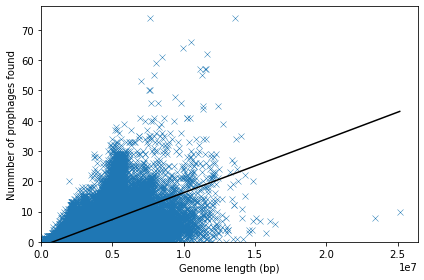

In [12]:
df['kept fit'] = (keptmodel.params['Genome length'] * df['Genome length']) + keptmodel.params['const']
ax = sns.scatterplot(x='Genome length', y='Kept', data=df, marker='x')
sns.lineplot(x='Genome length', y='kept fit', data=df, color='k')
ax.set_ylabel('Nummber of prophages found')
ax.set_xlabel('Genome length (bp)')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/num_kept.png')

## Compare number of prophages and total prophage bp

This bloody ought to be +ve!

The equation is 17467.798x + 31715.168
The R-squared is 0.772
The p-value for number of phages kept is 0.000


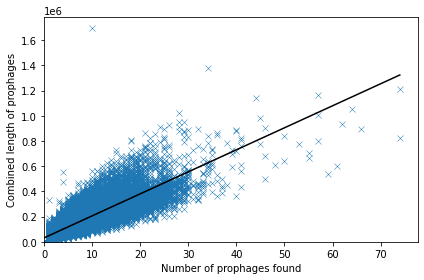

In [13]:
exog = sm.add_constant(df["Kept"])
keptvlen = sm.OLS(df["bp prophage"], exog).fit()
print(f"The equation is {keptvlen.params['Kept']:.3f}x + {keptvlen.params['const']:.3f}")
print(f"The R-squared is {keptvlen.rsquared:.3f}")
print(f"The p-value for number of phages kept is {keptvlen.pvalues['Kept']:.3f}")
df['kept vs bp fit'] = (keptvlen.params['Kept'] * df['Kept']) + keptvlen.params['const']
ax = sns.scatterplot(x='Kept', y='bp prophage', data=df, marker='x')
sns.lineplot(x='Kept', y='kept vs bp fit', data=df, color='k')
ax.set_ylabel('Combined length of prophages')
ax.set_xlabel('Number of prophages found')
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.tight_layout() 
fig = ax.get_figure()
fig.savefig('images/keptpplen.png')

### Is there a relationship between # contigs and # phages?

This could be a relationship, especially as a genome gets fragmented.

In [14]:
exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs total pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']

exog = sm.add_constant(df["Contigs"])
model = sm.OLS(df["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
df['contigs vs kept pp'] = (model.params['Contigs'] * df['Contigs']) + model.params['const']


For TOTAL prophages
The equation is 0.222x + 24.304
The R-squared is 0.249
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is 0.020x + 4.450
The R-squared is 0.058
The p-value for number of phages kept is 0.000


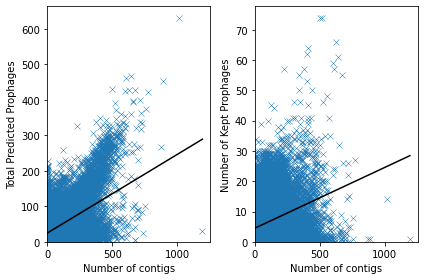

In [15]:
fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=df, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=df, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=df, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=df, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/contigspp.png')

How many contigs are there?

(-10.0, 25.0)

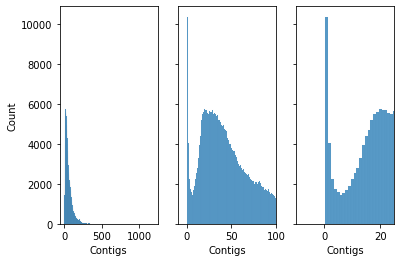

In [16]:
fig, ax =plt.subplots(ncols=3, sharey=True)
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[0])
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[1])
sns.histplot(x='Contigs', data=df, discrete=True, ax=ax[2])
ax[1].set_xlim(-10, 100)
ax[2].set_xlim(-10, 25)

#### Repeating, but only for genomes > 20 contigs

I think the graph is being strongly skewed at the bottom.

In [17]:
ndraft = 20
print(f"There are {sum(df['Contigs'] < ndraft):,} contigs less than {ndraft} contigs")

There are 66,910 contigs less than 20 contigs



For TOTAL prophages in draft genomes > 20 contigs
The equation is 0.218x +b 24.866 and r**2=0.231

For KEPT prophages
The equation is 0.015x + 5.085 and r**2=0.029


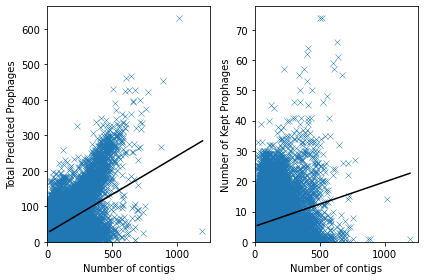

In [18]:
dfdrafts = df[df['Contigs'] > ndraft].copy()
dfdrafts.drop(['contigs vs kept pp', 'contigs vs total pp'], axis=1)
exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Total Predicted Prophages"], exog).fit()
print(f"\nFor TOTAL prophages in draft genomes > {ndraft} contigs")
print(f"The equation is {model.params['Contigs']:.3f}x +b {model.params['const']:.3f} and r**2={model.rsquared:.3f}")

dfdrafts['contigs vs total pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

exog = sm.add_constant(dfdrafts["Contigs"])
model = sm.OLS(dfdrafts["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f} and r**2={model.rsquared:.3f}")
dfdrafts['contigs vs kept pp'] = (model.params['Contigs'] * dfdrafts['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=dfdrafts, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=dfdrafts, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=dfdrafts, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=dfdrafts, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/draftcontigspp.png')

# Filter to sequences with less than 20 contigs

In [19]:
ndraft=20
df = df[df['Contigs'] < ndraft].copy()
df.shape

(66910, 14)

## Some general data about the prophages

In [20]:
print(f"There are {df['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {df['bp prophage'].mean():,.0f} bp, so {df['bp prophage'].mean()/df['Kept'].mean():,.0f} bp per prophage")

There are 3.47 prophages per genome on average, with a mean combined length of 108,010 bp, so 31,128 bp per prophage


In [21]:
print(f"The most prophages is {max(df['Kept'])} in {df.iloc[df['Kept'].argmax()]['Contig']}")
print(f"The longest combined amount of prophage DNA is {max(df['bp prophage'])} in {df.iloc[df['bp prophage'].argmax()]['Contig']}")
print(f"The highest fraction of prophage DNA is {max(df['fraction pp']) * 100:.3f}% in {df.iloc[df['fraction pp'].argmax()]['Contig']}")

The most prophages is 34 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The longest combined amount of prophage DNA is 1381126 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz
The highest fraction of prophage DNA is 99.829% in GCA_900143735.1_contig1_genomic.gbff.gz


Text(0.5, 0, 'Number of prophages identified')

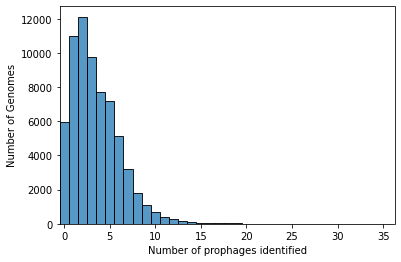

In [22]:
ax = sns.histplot(df['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")

# Filtered Data Set

Lets filter out anything in more than 10 contigs. This should be essentially complete genomes and remove any bias from fragmented genomes

In [23]:
filtermax=10
print(f"Before filtering we have {df.shape[0]:,} genomes")
fdf = df[df['Contigs'] < filtermax].copy()
fdf.reset_index().drop('index', axis=1)
print(f"After filtering for genomes with less than {filtermax} contigs we have {fdf.shape[0]:,} genomes")

Before filtering we have 66,910 genomes
After filtering for genomes with less than 10 contigs we have 26,640 genomes


In [24]:
print(f"After filtering for genomes with less than {filtermax} contigs")
print(f"There are {fdf['Kept'].mean():.2f} prophages per genome on average, with a mean combined length of {fdf['bp prophage'].mean():,.0f} bp, so {fdf['bp prophage'].mean()/fdf['Kept'].mean():,.0f} bp per prophage")

After filtering for genomes with less than 10 contigs
There are 3.63 prophages per genome on average, with a mean combined length of 117,874 bp, so 32,500 bp per prophage


In [25]:
print(f"The most prophages is {max(fdf['Kept'])} in {fdf.iloc[fdf['Kept'].argmax()]['Contig']} that has {fdf.iloc[fdf['Kept'].argmax()]['Contigs']} contigs")
print(f"The longest combined amount of prophage DNA is {max(fdf['bp prophage'])} in {fdf.iloc[fdf['bp prophage'].argmax()]['Contig']} that has {fdf.iloc[fdf['bp prophage'].argmax()]['Contigs']} contigs")
print(f"The highest fraction of prophage DNA is {max(fdf['fraction pp']) * 100:.3f}% in {fdf.iloc[fdf['fraction pp'].argmax()]['Contig']}")

The most prophages is 34 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz that has 9 contigs
The longest combined amount of prophage DNA is 1381126 in GCA_000178855.1_ASM17885v1_genomic.gbff.gz that has 9 contigs
The highest fraction of prophage DNA is 99.829% in GCA_900143735.1_contig1_genomic.gbff.gz


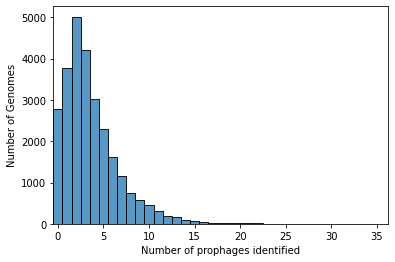

In [26]:
ax = sns.histplot(fdf['Kept'], discrete=True)
ax.set_xlim(-0.5,)
ax.set_ylabel("Number of Genomes")
ax.set_xlabel("Number of prophages identified")
fig = ax.get_figure()
fig.savefig('images/pp_hist.png')

### There is no dependency on number of contigs now

When we drop highly fragmented (draft) genomes, we loose the dependency on the number of contigs completely.


For TOTAL prophages
The equation is -0.614x + 28.844
The R-squared is 0.006
The p-value for number of phages kept is 0.000

For KEPT prophages
The equation is -0.037x + 3.752
The R-squared is 0.001
The p-value for number of phages kept is 0.000


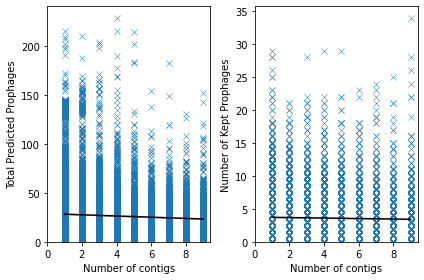

In [27]:
fdf.drop(['contigs vs total pp', 'contigs vs kept pp'], axis=1)

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Total Predicted Prophages"], exog).fit()
print("\nFor TOTAL prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs total pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

exog = sm.add_constant(fdf["Contigs"])
model = sm.OLS(fdf["Kept"], exog).fit()
print("\nFor KEPT prophages")
print(f"The equation is {model.params['Contigs']:.3f}x + {model.params['const']:.3f}")
print(f"The R-squared is {model.rsquared:.3f}")
print(f"The p-value for number of phages kept is {model.pvalues['Contigs']:.3f}")
fdf['contigs vs kept pp'] = (model.params['Contigs'] * fdf['Contigs']) + model.params['const']

fig, ax =plt.subplots(ncols=2, sharey=False)

sns.scatterplot(x='Contigs', y='Total Predicted Prophages', data=fdf, marker='x', ax=ax[0])
sns.lineplot(x='Contigs', y='contigs vs total pp', data=fdf, color='k', ax=ax[0])
ax[0].set_ylabel('Total Predicted Prophages')

sns.scatterplot(x='Contigs', y='Kept', data=fdf, marker='x', ax=ax[1])
sns.lineplot(x='Contigs', y='contigs vs kept pp', data=fdf, color='k', ax=ax[1])
ax[1].set_ylabel('Number of Kept Prophages')

for a in ax:
    a.set_xlim(0,)
    a.set_ylim(0,)
    a.set_xlabel('Number of contigs')
    
plt.tight_layout() 

fig.savefig('images/filteredcontigspp.png')

# Size distributions

This is mostly for Toni Luque who is really interested in the size distributions of the prophages.